# Starter notebook for NIH Chest Xray

## Copy data from GCS (if not so yet)

In [1]:
# user-specific setting
PROJECT = 'mcsds-dlh'  # CHANGE: billing project name (since the dataset is user-to-pay)
DATA_FOLDER = 'data/raw/'

In [2]:
# Download images from GCS. Takes a few minutes.
# https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest#gcp_data_access

#!gsutil -u {PROJECT} -m -q cp -r gs://gcs-public-data--healthcare-nih-chest-xray/png/*.png {DATA_FOLDER}

# Download addition labels
# https://pubs.rsna.org/doi/10.1148/radiol.2019191293

#!gsutil -u {PROJECT} -m -q cp -r gs://gcs-public-data--healthcare-nih-chest-xray-labels/* {DATA_FOLDER}

# Code starts here

In [3]:
# import libraries
import pandas as pd
import numpy as np
import random
import os
import torch
from torch.utils.data import Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# check if CUDA is available (GPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cpu


In [4]:
# set seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [5]:
# explore the dataset
# load train test split
with open('train_val_list.txt') as f: 
    train_val_list = [x.strip() for x in f.readlines()]
with open('test_list.txt') as f:
    test_list = [x.strip() for x in f.readlines()]

# load labels
df_labels = pd.read_csv('Data_Entry_2017_v2020.csv')
print(f"Number of images: {len(df_labels)}")
# split the finding (disease) labels, to a list
df_labels['targets'] = df_labels['Finding Labels'].str.split("|", expand = False)
# look at available labels
labels = set([item for sublist in df_labels['targets'].tolist() for item in sublist])

print(f"Number of labels: {len(labels)}")
print(f"Labels: {labels}")

# one-hot encode labels to columns
mlb = MultiLabelBinarizer(sparse_output=True)

df_labels = df_labels.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df_labels.pop('targets')),
                index=df_labels.index,
                columns=mlb.classes_))
df_labels[list(labels)]=df_labels[list(labels)].sparse.to_dense()  # for easy .describe()

# show converted data
df_labels[['Finding Labels', *list(labels)]].head(10)

Number of images: 112120
Number of labels: 15
Labels: {'Atelectasis', 'Infiltration', 'Hernia', 'Pneumothorax', 'Edema', 'Consolidation', 'No Finding', 'Pleural_Thickening', 'Cardiomegaly', 'Effusion', 'Nodule', 'Emphysema', 'Pneumonia', 'Mass', 'Fibrosis'}


Finding Labels 
 Atelectasis 
 Infiltration 
 Hernia 
 Pneumothorax 
 Edema 
 Consolidation 
 No Finding 
 Pleural_Thickening 
 Cardiomegaly 
 Effusion 
 Nodule 
 Emphysema 
 Pneumonia 
 Mass 
 Fibrosis 
 
 
 
 
 0 
 Cardiomegaly 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 1 
 Cardiomegaly|Emphysema 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 1 
 0 
 0 
 1 
 0 
 0 
 0 
 
 
 2 
 Cardiomegaly|Effusion 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 0 
 0 
 1 
 
 
 3 
 No Finding 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 4 
 Hernia 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 5 
 Hernia 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 6 
 Hernia|Infiltration 
 0 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 1 
 0 
 0 
 0 
 
 
 7 
 Hernia 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 8 
 Hernia 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 9 
 Hernia 
 0 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0

In [6]:
df_labels.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,00025730_000.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.573751,14346.381743,46.626365,NaN,NaN,2646.078844,2486.438842,0.155649,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,NaN,NaN,15.406320,8403.876972,16.602680,NaN,NaN,341.246429,401.268227,0.016174,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,1143.000000,966.000000,0.115000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,7310.750000,34.000000,NaN,NaN,2500.000000,2048.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
# split into train_val and test sets
df_train_val = df_labels[df_labels['Image Index'].isin(train_val_list)]
df_test = df_labels[df_labels['Image Index'].isin(test_list)]

print(f"Number of train/val images: {len(df_train_val)}")
print(f"Number of test images: {len(df_test)}")

assert (len(df_train_val) + len(df_test)) == len(df_labels), "Total number of images does not equal to sum of train/val and test!"

Number of train/val images: 86524
Number of test images: 25596


In [9]:
# read images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
i=54756

print(df_labels['Image Index'][i])
path_to_img = os.path.join('../data/raw/images', df_labels['Image Index'][i])

img=mpimg.imread(path_to_img)
print(f"Image size: {img.shape}")  # 2D
print(img.max(), img.min())  # grayscale [0.0, 1.0]
print(df_labels['Patient Age'][i])
print(df_labels['Patient Gender'][i])
print(df_labels['View Position'][i])  # only AP/PA, no lateral
# Plot an image
imgplot = plt.imshow(img, cmap='gray')

00013685_059.png
Image size: (1024, 1024)
0.87058824 0.003921569
49
F
AP


Take the label *Atelectasis* as pivot, let's build a classifier for it.

Settings:
1. Consider only PA view images.
2. Binary classification.

In [10]:
disease = 'Atelectasis'

In [11]:
df_labels.describe(include='all')

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
count,112120,112120,112120.000000,112120.000000,112120.000000,112120,112120,112120.000000,112120.000000,112120.000000,...,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000
unique,112120,836,NaN,NaN,NaN,2,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,00025730_000.png,No Finding,NaN,NaN,NaN,M,PA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,60361,NaN,NaN,NaN,63340,67310,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,8.573751,14346.381743,46.626365,NaN,NaN,2646.078844,2486.438842,0.155649,...,0.022440,0.015037,0.002025,0.177435,0.051570,0.538361,0.056466,0.030191,0.012763,0.047289
std,NaN,NaN,15.406320,8403.876972,16.602680,NaN,NaN,341.246429,401.268227,0.016174,...,0.148111,0.121702,0.044950,0.382038,0.221158,0.498529,0.230821,0.171113,0.112251,0.212256
min,NaN,NaN,0.000000,1.000000,0.000000,NaN,NaN,1143.000000,966.000000,0.115000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,7310.750000,34.000000,NaN,NaN,2500.000000,2048.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,3.000000,13993.000000,49.000000,NaN,NaN,2518.000000,2544.000000,0.143000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,10.000000,20673.000000,59.000000,NaN,NaN,2992.000000,2991.000000,0.168000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000


Fraction of positive class: 0.538


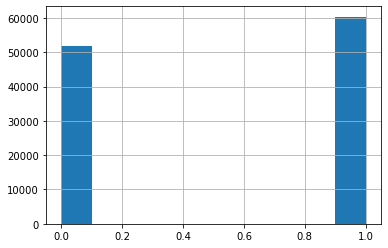

In [11]:
# Label distribution
df_labels.describe(include='all')
df_labels[disease].hist()

In [13]:
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df_train_val, test_size=0.2,random_state=seed)  # 20% val set, about same size as test

assert len(df_train) + len(df_val) == len(df_train_val)

# Prepare train/val and test data
def select_images(df):
    df = df[df['View Position']=='PA'].reset_index()
    return df

df_train_pa = select_images(df_train)
df_val_pa = select_images(df_val)
df_test_pa = select_images(df_test)

print(f"# train images: {df_train_pa.shape[0]}")
print(f"# val images: {df_val_pa.shape[0]}")
print(f"# test images: {df_test_pa.shape[0]}")

# train images: 44954
# val images: 11260
# test images: 11096


**Warning: The validation images serve as test set. Do NOT use them for model tuning.**
Use leave-out set/CV on training images for tuning instead.

Now we have the images and labels. We can train our model.

In [49]:
# Loader

class NihDataset(Dataset):
    def __init__(self, dataframe, root_dir, label, transform=None):
        """
        label: column name of the label of interest, e.g. 'Pleural Effusion'.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.label = label
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join('../', self.root_dir, 'images/',self.dataframe.loc[idx, 'Image Index'])
        image = Image.open(img_name).convert('L')  # via .getband(), some images are know to have 4 channels. Here we convert them to 1-channel grayscale.
        target = self.dataframe.loc[idx, disease]
            
        if self.transform:
            image = self.transform(image)
        
        return image, target
        

In [50]:
# Data loaders to return batch of images
def load_data(dataframe, root_dir, label, transform=None, batch_size=32, shuffle=True, num_workers=0):
    '''
    Data Loader with batch loading and transform.
    '''
    image_data = NihDataset(dataframe, root_dir, label, transform=transform)
    pin = device=='cpu'
    loader = torch.utils.data.DataLoader(image_data, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers, pin_memory=pin)
    return loader

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((112,112)),
        transforms.RandomHorizontalFlip(),  # data augmentation
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.CenterCrop(112),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Define our CNN architecture:

In [51]:
# Helper function
def conv_output_volume(W, F, S, P):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int((W - F + 2*P) / S) + 1

def maxpool_output_volume(W, F, S):
    
    """
    Given the input volume size $W$, the kernel/filter size $F$, 
    the stride $S$, and the amount of zero padding $P$ used on the border, 
    calculate the output volume size.
    """
    return int(np.ceil((W - F + 1) / S))

conv_layer1_size = conv_output_volume(W=112, F=5, S=1, P=0)
maxpool_layer1_size = maxpool_output_volume(W=conv_layer1_size, F=2, S=2)

conv_layer2_size = conv_output_volume(W=maxpool_layer1_size, F=5, S=1, P=0)
maxpool_layer2_size = maxpool_output_volume(W=conv_layer2_size, F=2, S=2)

print(conv_layer1_size, maxpool_layer1_size, conv_layer2_size, maxpool_layer2_size)

108 54 50 25


In [52]:
# For now, just use a simple one from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html, plus dropout

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)  # stride=1, padding=0
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(3, 8, 5)
        self.fc1 = nn.Linear(8 * 25 * 25, 60)
        self.fc2 = nn.Linear(60, 20)
        self.fc3 = nn.Linear(20, 2)  # 2 classes
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # size: (batch_size*)3channels*110*110
        x = self.pool(F.relu(self.conv2(x)))  # size: (batch_size*)8channels*53*53
        x = x.view(-1, 8 * 25 * 25)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)  # no softmax necessary as CrossEntropyLoss will take care. See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
        return x

model = Net().to(device)

In [53]:
# Define loss function and optimizer

import torch.optim as optim

criterion = nn.BCELoss()  # change to CrossEntropyLoss if  multiclass
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [54]:
# Define loss function and optimizer

import torch.optim as optim
num_neg = sum(df_train_pa[disease] == 0)
num_pos = sum(df_train_pa[disease] == 1)
assert num_neg + num_pos == len(df_train_pa)
print(f"# of negative/positive cases: {num_neg}:{num_pos}")

# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
class_weight = torch.FloatTensor([(1 / num_neg)*(len(df_train_pa))/2.0, (1 / num_pos)*(len(df_train_pa))/2.0]).to(device)
print(f"Class weight: {class_weight}")

#criterion = nn.CrossEntropyLoss()  # change to CrossEntropyLoss if  multiclass
criterion = nn.CrossEntropyLoss(weight=class_weight)  # change to CrossEntropyLoss if  multiclass
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# of negative/positive cases: 17325:27629
Class weight: tensor([1.2974, 0.8135])


In [18]:
def train_model(model, train_loader, valid_loader, num_epochs=10, verbose=True):
    start_time = time.time()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        print(f"Epoch {epoch+1}")
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.type(torch.LongTensor).to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics every 10 batches
            running_loss += loss.item()
            if verbose:
                if i % 10 == 9:    # print every 10 mini-batches
                    print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / (i+1)))
        train_losses.append(running_loss/len(train_data_loader))  # keep trace of train loss in each epoch
        print(f'Time elapsed: {(time.time()-start_time)/60.0:.1f} minutes.')
        
        # validate every epoch
        print("Validating...")
        val_loss, _, _, _ = eval_model(model, valid_loader)
        val_losses.append(val_loss/len(val_data_loader))  # keep trace of validation loss in each epoch
        print("Epoch: {}/{}.. ".format(epoch+1, num_epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Validation Loss: {:.3f}.. ".format(val_losses[-1]))
        
        # save the model every epoch
        MODEL_PATH = f'../models/simple_net_{time.time()}_epoch{num_epochs}.pth'
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model saved!")
        
    return model, train_losses, val_losses

def eval_model(model, loader):
    from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
    # validate every epoch
    loss = 0.0
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        model.eval()
        # empty tensors to hold results
        Y_prob, Y_true, Y_pred = [], [], []
        for inputs, labels in loader:
            probs = model(inputs.to(device)) # prediction probability
            labels = labels.type(torch.LongTensor).to(device)  # true labels
            _, predicted = torch.max(probs, dim=1)
            # stack results
            Y_prob.append(probs[:,-1])  # probability of positive class
            Y_true.append(labels)
            Y_pred.append(predicted)
            
            loss += criterion(probs, labels)

    # convert to numpy
    Y_prob = torch.cat(Y_prob).detach().cpu().numpy()
    Y_pred = torch.cat(Y_pred).detach().cpu().numpy()
    Y_true = torch.cat(Y_true).detach().cpu().numpy()

    # TODO: use desired metrics here
    print(f"ROC: {roc_auc_score(Y_true, Y_prob):.3f}")
    fpr, tpr, _ = roc_curve(Y_true, Y_prob)
    auc = roc_auc_score(Y_true, Y_prob)
    plt.figure()
    plt.plot(fpr,tpr,label=f"Validation, ROCAUC={auc:3f}")
    plt.legend(loc=4)
    plt.show()
    
    print(classification_report(Y_true, Y_pred))
    plt.figure()
    cm = confusion_matrix(Y_true, Y_pred)  # confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
     
    return loss, Y_prob, Y_pred, Y_true

In [22]:
#loss, Y_prob, Y_pred, Y_true = eval_model(model, val_data_loader)

In [20]:
#pd.DataFrame(Y_prob).hist()

Training start. Mode: cpu
Epoch 1
Time elapsed: 5.7 minutes.
Validating...
ROC: 0.608


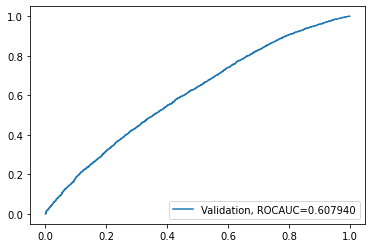

              precision    recall  f1-score   support

           0       0.46      0.60      0.52      4392
           1       0.68      0.55      0.61      6868

    accuracy                           0.57     11260
   macro avg       0.57      0.57      0.56     11260
weighted avg       0.60      0.57      0.57     11260

Epoch: 1/10..  Training Loss: 0.691..  Validation Loss: 0.682.. 
Model saved!
Epoch 2
Time elapsed: 12.9 minutes.
Validating...
ROC: 0.611


<Figure size 432x288 with 0 Axes>

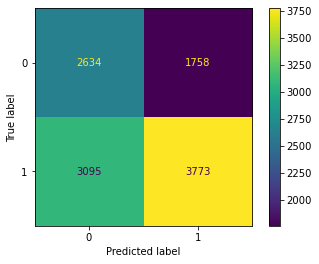

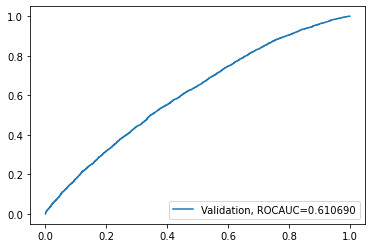

              precision    recall  f1-score   support

           0       0.48      0.50      0.49      4392
           1       0.67      0.65      0.66      6868

    accuracy                           0.59     11260
   macro avg       0.58      0.58      0.58     11260
weighted avg       0.60      0.59      0.59     11260

Epoch: 2/10..  Training Loss: 0.688..  Validation Loss: 0.678.. 
Model saved!
Epoch 3
Time elapsed: 20.2 minutes.
Validating...
ROC: 0.619


<Figure size 432x288 with 0 Axes>

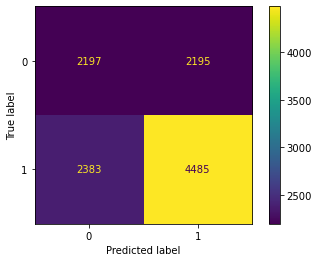

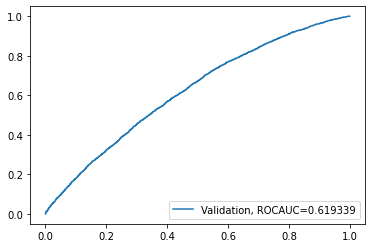

              precision    recall  f1-score   support

           0       0.53      0.37      0.43      4392
           1       0.66      0.79      0.72      6868

    accuracy                           0.63     11260
   macro avg       0.60      0.58      0.58     11260
weighted avg       0.61      0.63      0.61     11260

Epoch: 3/10..  Training Loss: 0.687..  Validation Loss: 0.677.. 
Model saved!
Epoch 4
Time elapsed: 27.6 minutes.
Validating...
ROC: 0.623


<Figure size 432x288 with 0 Axes>

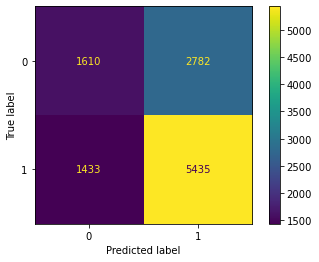

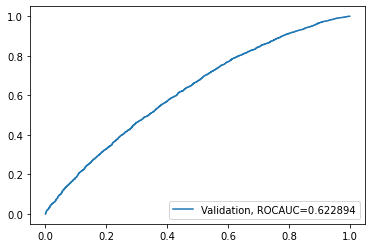

              precision    recall  f1-score   support

           0       0.48      0.58      0.52      4392
           1       0.69      0.59      0.64      6868

    accuracy                           0.59     11260
   macro avg       0.58      0.59      0.58     11260
weighted avg       0.61      0.59      0.59     11260

Epoch: 4/10..  Training Loss: 0.685..  Validation Loss: 0.672.. 
Model saved!
Epoch 5
Time elapsed: 34.7 minutes.
Validating...
ROC: 0.629


<Figure size 432x288 with 0 Axes>

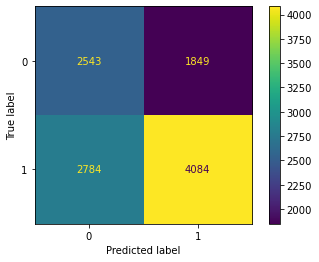

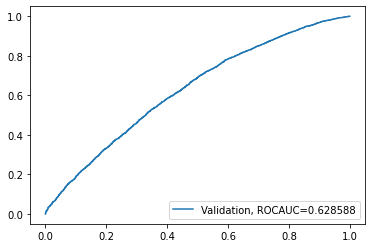

              precision    recall  f1-score   support

           0       0.49      0.54      0.51      4392
           1       0.69      0.65      0.67      6868

    accuracy                           0.60     11260
   macro avg       0.59      0.59      0.59     11260
weighted avg       0.61      0.60      0.61     11260

Epoch: 5/10..  Training Loss: 0.684..  Validation Loss: 0.671.. 
Model saved!
Epoch 6
Time elapsed: 42.0 minutes.
Validating...
ROC: 0.629


<Figure size 432x288 with 0 Axes>

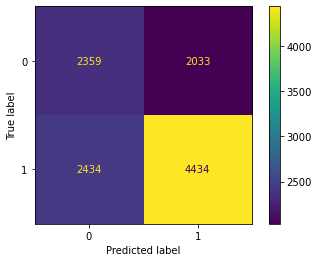

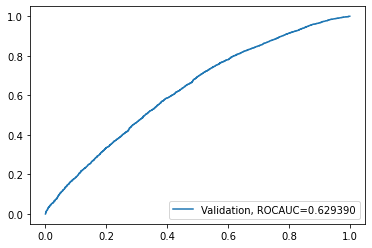

              precision    recall  f1-score   support

           0       0.55      0.36      0.44      4392
           1       0.67      0.81      0.73      6868

    accuracy                           0.64     11260
   macro avg       0.61      0.59      0.58     11260
weighted avg       0.62      0.64      0.62     11260

Epoch: 6/10..  Training Loss: 0.682..  Validation Loss: 0.670.. 
Model saved!
Epoch 7
Time elapsed: 49.2 minutes.
Validating...
ROC: 0.633


<Figure size 432x288 with 0 Axes>

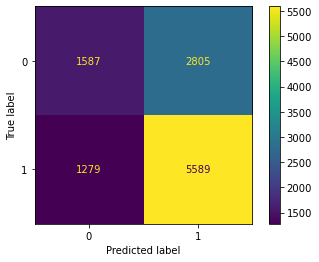

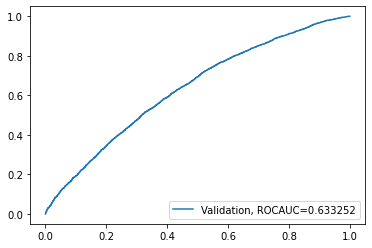

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      4392
           1       0.69      0.68      0.68      6868

    accuracy                           0.61     11260
   macro avg       0.60      0.60      0.60     11260
weighted avg       0.62      0.61      0.61     11260

Epoch: 7/10..  Training Loss: 0.684..  Validation Loss: 0.673.. 
Model saved!
Epoch 8
Time elapsed: 56.5 minutes.
Validating...
ROC: 0.637


<Figure size 432x288 with 0 Axes>

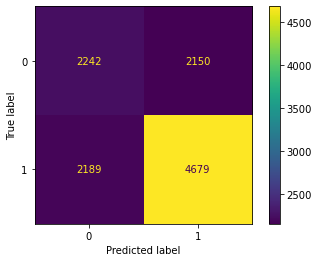

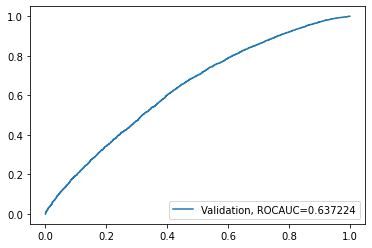

              precision    recall  f1-score   support

           0       0.51      0.53      0.52      4392
           1       0.69      0.67      0.68      6868

    accuracy                           0.62     11260
   macro avg       0.60      0.60      0.60     11260
weighted avg       0.62      0.62      0.62     11260

Epoch: 8/10..  Training Loss: 0.682..  Validation Loss: 0.666.. 
Model saved!
Epoch 9
Time elapsed: 63.8 minutes.
Validating...
ROC: 0.637


<Figure size 432x288 with 0 Axes>

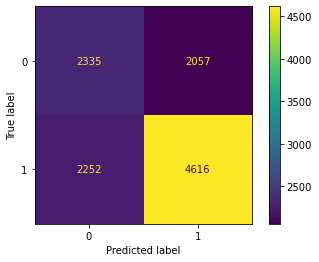

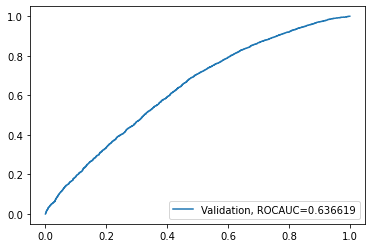

              precision    recall  f1-score   support

           0       0.55      0.41      0.47      4392
           1       0.68      0.78      0.72      6868

    accuracy                           0.64     11260
   macro avg       0.61      0.60      0.60     11260
weighted avg       0.62      0.64      0.62     11260

Epoch: 9/10..  Training Loss: 0.682..  Validation Loss: 0.666.. 
Model saved!
Epoch 10
Time elapsed: 70.9 minutes.
Validating...
ROC: 0.632


<Figure size 432x288 with 0 Axes>

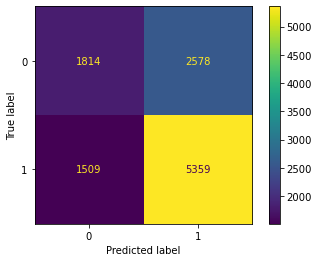

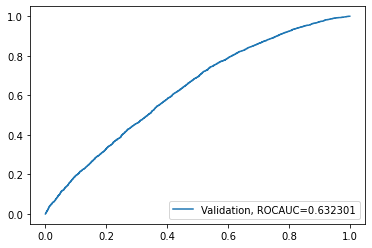

              precision    recall  f1-score   support

           0       0.51      0.50      0.51      4392
           1       0.69      0.70      0.69      6868

    accuracy                           0.62     11260
   macro avg       0.60      0.60      0.60     11260
weighted avg       0.62      0.62      0.62     11260

Epoch: 10/10..  Training Loss: 0.681..  Validation Loss: 0.665.. 
Model saved!
Finished Training. Total time: 4342.969681739807 secs.


<Figure size 432x288 with 0 Axes>

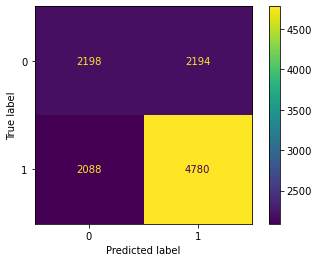

In [21]:
import time

num_epochs = 10
batch_size = 256

train_data_loader = load_data(df_train_pa, DATA_FOLDER, disease, transform=data_transforms['train'], shuffle=True, batch_size=batch_size)
val_data_loader = load_data(df_val_pa, DATA_FOLDER, disease, transform=data_transforms['test'], shuffle=False, batch_size=32)

print(f"Training start. Mode: {device}")
start_time = time.time()
model, t_losses, v_losses = train_model(model, train_data_loader, val_data_loader, num_epochs=num_epochs, verbose=False)
print(f'Finished Training. Total time: {time.time()-start_time} secs.')

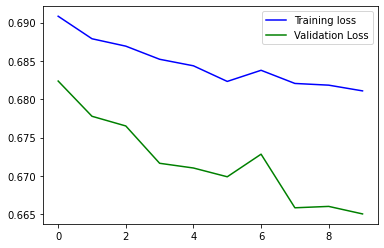

In [22]:
# plot training and validation loss over epoches
plt.figure()
plt.plot(t_losses, 'b', label='Training loss')
plt.plot(v_losses, 'g', label='Validation Loss')
plt.legend()
plt.show()

ROC: 0.551


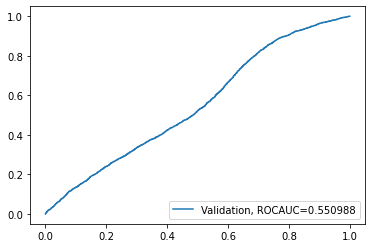

              precision    recall  f1-score   support

           0       0.58      0.66      0.62      6291
           1       0.45      0.37      0.41      4805

    accuracy                           0.53     11096
   macro avg       0.52      0.51      0.51     11096
weighted avg       0.52      0.53      0.53     11096



<Figure size 432x288 with 0 Axes>

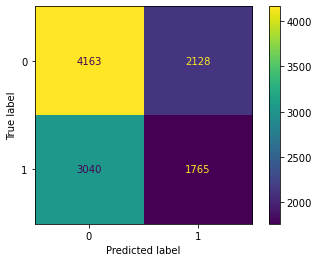

In [23]:
# Evaluate on test set
test_data_loader = load_data(df_test_pa, DATA_FOLDER, disease, transform=data_transforms['test'], shuffle=False, batch_size=32)
test_loss, t_prob, t_pred, t_true = eval_model(model, test_data_loader)